# 2022 Fantasy Basketball Statistical Analysis


This is a jupyter notebook detailing statistical approach of 2022 Fantasy Basketball Analysis using various data science methods

Data extracted from https://www.basketball-reference.com/playoffs/NBA_2020_totals.html

In [87]:
import psycopg2 as pg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
import warnings
warnings.filterwarnings('ignore')

## 1) Get the data from PostgreSQL server to Pandas Dataframe

In [88]:
con = pg.connect(database="playerdata", user="postgres" , password = " ")

# We will fill NaN values with 0 (this is reasonable as empty cell means no data -> 0 statistics)
playoff_2019 = pd.read_sql('SELECT * FROM "2019"', con)
playoff_2019.fillna(0, inplace=True)

playoff_2020 = pd.read_sql('SELECT * FROM "2020"', con)
playoff_2020.fillna(0, inplace=True)

playoff_2021 = pd.read_sql('SELECT * FROM "2021"', con)
playoff_2021.fillna(0, inplace=True)

playoff_2019

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1,Steven Adams,C,25,OKC,5,5,159,28,42,0.667,0,1,0.000,28,41,0.683,0.667,3,8,0.375,12,24,36,7,5,5,9,13,59
1,2,LaMarcus Aldridge,C,33,SAS,7,7,244,55,121,0.455,3,11,0.273,52,110,0.473,0.467,27,33,0.818,19,48,67,19,5,7,7,21,140
2,3,Grayson Allen,SG,23,UTA,2,0,14,2,7,0.286,0,3,0.000,2,4,0.500,0.286,5,7,0.714,0,1,1,0,0,0,0,0,9
3,4,Jarrett Allen,C,20,BRK,5,5,110,19,32,0.594,0,0,0.000,19,32,0.594,0.594,17,20,0.850,15,19,34,11,3,3,8,13,55
4,5,Al-Farouq Aminu,PF,28,POR,16,16,399,38,109,0.349,15,51,0.294,23,58,0.397,0.417,27,36,0.750,29,71,100,21,9,10,16,34,118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,208,Robert Williams,C,21,BOS,3,0,13,1,2,0.500,0,0,0.000,1,2,0.500,0.500,2,2,1.000,1,6,7,0,0,0,0,1,4
208,209,D.J. Wilson,PF,22,MIL,8,0,43,8,16,0.500,1,5,0.200,7,11,0.636,0.531,2,2,1.000,1,9,10,4,0,1,7,7,19
209,210,Guerschon Yabusele,PF,23,BOS,4,0,14,2,4,0.500,0,1,0.000,2,3,0.667,0.500,4,7,0.571,1,1,2,1,0,1,1,3,8
210,211,Thaddeus Young,PF,30,IND,4,4,130,18,42,0.429,2,8,0.250,16,34,0.471,0.452,4,7,0.571,9,19,28,15,11,3,5,10,42


The database "Playerdata" is individual player total statistics in the playoffs.

This data does not contain statistics from regular season matches/games. Thus significantly less pool of NBA players. 

We will connect to a second database called "SeasonData". This is player statistics accumulated over the entire NBA regular season matches. 


In [89]:
con2 = pg.connect(database="SeasonData", user="postgres" , password = " ")

# We will fill NaN values with 0 (this is reasonable as empty cell means no data -> 0 statistics)
season_2019 = pd.read_sql('SELECT * FROM "2019Season"', con2)
season_2019.fillna(0, inplace=True)

season_2020 = pd.read_sql('SELECT * FROM "2020Season"', con2)
season_2020.fillna(0, inplace=True)

season_2021 = pd.read_sql('SELECT * FROM "2021Season"', con2)
season_2021.fillna(0, inplace=True)

season_2019

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1,Alex Abrines,SG,25,OKC,31,2,588,56,157,0.357,41,127,0.323,15,30,0.500,0.487,12,13,0.923,5,43,48,20,17,6,14,53,165
1,2,Quincy Acy,PF,28,PHO,10,0,123,4,18,0.222,2,15,0.133,2,3,0.667,0.278,7,10,0.700,3,22,25,8,1,4,4,24,17
2,3,Jaylen Adams,PG,22,ATL,34,1,428,38,110,0.345,25,74,0.338,13,36,0.361,0.459,7,9,0.778,11,49,60,65,14,5,28,45,108
3,4,Steven Adams,C,25,OKC,80,80,2669,481,809,0.595,0,2,0.000,481,807,0.596,0.595,146,292,0.500,391,369,760,124,117,76,135,204,1108
4,5,Bam Adebayo,C,21,MIA,82,28,1913,280,486,0.576,3,15,0.200,277,471,0.588,0.579,166,226,0.735,165,432,597,184,71,65,121,203,729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
703,528,Tyler Zeller,C,29,MEM,4,1,82,16,28,0.571,0,0,0.000,16,28,0.571,0.571,14,18,0.778,9,9,18,3,1,3,4,16,46
704,529,Ante Zizic,C,22,CLE,59,25,1082,183,331,0.553,0,0,0.000,183,331,0.553,0.553,93,132,0.705,108,212,320,53,13,22,61,113,459
705,530,Ivica Zubac,C,21,TOT,59,37,1040,212,379,0.559,0,0,0.000,212,379,0.559,0.559,101,126,0.802,115,247,362,63,14,51,70,137,525
706,530,Ivica Zubac,C,21,LAL,33,12,516,112,193,0.580,0,0,0.000,112,193,0.580,0.580,57,66,0.864,54,108,162,25,4,27,33,73,281


Note that some players have more than 1 entry. This is due to NBA official trades between teams during regular season.

To combat multiple entries, I will be looking at entry with Team of "TOT" (Totals: culminated statistics of player x) for those individuals with trades.

Ex) line 705-707, player "Ivica Zubac" has 3 entries due to 1 trade from LA Lakers to LA Clippers. We will only use "TOT"

In [5]:
def remove_trade(df):
    """
    Helper function to remove trades in the dataset.
    Only use total statistics for traded NBA player.
    """
    player = df['Player'].unique()
    
    for ath in player:
        if len(df[df['Player'] == ath]) > 1:
            #checking if player has been traded
            #Get the index of the rows we want dropped i.e team is not TOT
            
            ind = df[(df['Player'] == ath) & (df['Tm'] != 'TOT')].index
            
            #drop the unwanted rows
            #Edit original dataset to remove traded players duplicating statistics
            
            df = df.drop(ind)
            
    return(df)        

In [90]:
season_2019 = remove_trade(season_2019)
season_2020 = remove_trade(season_2020)
season_2021 = remove_trade(season_2021)

season_2019

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1,Alex Abrines,SG,25,OKC,31,2,588,56,157,0.357,41,127,0.323,15,30,0.500,0.487,12,13,0.923,5,43,48,20,17,6,14,53,165
1,2,Quincy Acy,PF,28,PHO,10,0,123,4,18,0.222,2,15,0.133,2,3,0.667,0.278,7,10,0.700,3,22,25,8,1,4,4,24,17
2,3,Jaylen Adams,PG,22,ATL,34,1,428,38,110,0.345,25,74,0.338,13,36,0.361,0.459,7,9,0.778,11,49,60,65,14,5,28,45,108
3,4,Steven Adams,C,25,OKC,80,80,2669,481,809,0.595,0,2,0.000,481,807,0.596,0.595,146,292,0.500,391,369,760,124,117,76,135,204,1108
4,5,Bam Adebayo,C,21,MIA,82,28,1913,280,486,0.576,3,15,0.200,277,471,0.588,0.579,166,226,0.735,165,432,597,184,71,65,121,203,729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
699,526,Trae Young,PG,20,ATL,81,81,2503,525,1256,0.418,156,482,0.324,369,774,0.477,0.480,343,414,0.829,64,237,301,653,72,15,308,140,1549
700,527,Cody Zeller,C,26,CHO,49,47,1243,190,345,0.551,6,22,0.273,184,323,0.570,0.559,111,141,0.787,110,223,333,102,38,41,62,164,497
701,528,Tyler Zeller,C,29,TOT,6,1,93,16,30,0.533,0,1,0.000,16,29,0.552,0.533,14,18,0.778,11,13,24,4,1,3,4,20,46
704,529,Ante Zizic,C,22,CLE,59,25,1082,183,331,0.553,0,0,0.000,183,331,0.553,0.553,93,132,0.705,108,212,320,53,13,22,61,113,459


Here we simplified our dataset from 708 rows to 530 rows by removing unnecessary data.

## 2) Create Fantasy Metric

I will be creating Fantasy Metric. This is just generalized/regularized metric taken from statistics provided from NBA players.

Each position will have different ways of calculating Fantasy Metric, as different positions have different 'roles' (scoring, defense, etc)

For the metric I will be using the most played players from the last 3 championship winning teams (2019, 2020, 2021).

The Fantasy Metric for each player will be calculated using the following equation:

$$ Fantasy = W_1 \frac{Player_{FG\%}}{TOP_{FG\%}} + W_2 \frac{Player_{3P\%}}{TOP_{3P\%}} + ... + W_n \frac{Player_{PTS}}{TOP_{PTS}}$$

Above equation will get modified for different positions. We can also change each weights | $W_i$ | as we see fit.

### Basketball Roles

Now it's very important to know what each position is strong/weak at. This will allow me to select what weights, and what statistics I need in my equation. Here is my summary of each position from this article; https://www.basketballforcoaches.com/basketball-positions/

**Point Guard: (ex: Chris Paul, Stephen Curry)**
- Runs the offensive plays. 
- Best dribbler and passer on the team
- Offense -> pass rate, assist, points
- Defense -> steals, small turn over ratio

**Shooting Guard: (ex: James Harden, Fred Venvleet)**
- Best shooter on the team
- Offense -> PTS, 3point percentage, floaters, layups

**Small Forward: (ex: Lebron James, Kevin Durant)**
- Most versatile player on the team
- Usually team's best defensive player
- Offense -> Field goals
- Defense -> rebounds

**Power Forward: (ex: Tim Duncan, Giannis Antetokounmpo)**
- Plays close to the rim
- Offense -> three points, field goals
- Defense -> boxing out opponents, rebounds

**Center: (ex: Joel Embiid, Jarrett Allen)**
- Tallest, stronger player on the team, plays close to the rim
- Offense -> score close shots
- Defense -> blocks, steals

 ### Point Guard

For Point Guard I will be using the following equation

$$ Fantasy_{PG} = W_1 \frac{Player_{FG\%}}{TOP_{FG\%}} + W_2 \frac{Player_{3P\%}}{TOP_{3P\%}} + ... + W_n \frac{Player_{PTS}}{TOP_{PTS}}$$

The weights will all be 1 except for 2 Pointer, 3 Pointer, assists, steals and turn over ratio.

Weights are the following:
- 2 Pointer: 1.3
- 3 Pointer: 1.4
- Assists: 1.25
- Steals: 1.25
- Turn Over Ratio: -1.25



In [7]:
# Now let's get the denominators. 

c1 = season_2019[season_2019['Tm'] == 'TOR']
c2 = season_2020[season_2020['Tm'] == 'LAL']
c3 = season_2021[season_2021['Tm'] == 'MIL']

top3team = pd.concat([c1, c2, c3])

Here is one thing to note.

There are total of 72 season games played by each team. Each game consists of 48 minutes of playing time. Each team has about 13 players who can be active on a game (including bench and starters). 

$72 \times 48 = 3456$ minutes 

$3456 \div 13 = 265.8$ minutes

So mathematically, given equal playing time, each player will play for roughly 265 minutes during the whole season.

To remove biases/skewness (ex: Lorenzo Brown played 212 minutes with 100% free throw accuracy) in the statistics, **players with less than 265 minutes of gameplay will not be included in calculations.**

In [8]:
# Let's remove players with less than 265 minutes playing time.
top3team = top3team[top3team['MP'] > 265]

# We can now group by the position and get average statistics.
top3stat = top3team.groupby('Pos')[['FG%', '3P%', '2P%', 'eFG%', 'FT%']].mean()

# Here I only included % statistics. ORB, DRB, AST, STL, BLK, TOV, PTS are all affected by minutes played.
# Hence for those statistics, I will calculate per minute, ex)ORB/min, PTS/min

# Let's take a look at this statistic
top3stat

,FG%,3P%,2P%,eFG%,FT%
Pos,,,,,
C,0.584200,0.439800,0.62640,0.619200,0.701600
PF,0.491400,0.349400,0.52700,0.555400,0.810200
PG,0.438857,0.355857,0.49800,0.514286,0.761714
SF,0.474600,0.362000,0.52920,0.541200,0.720600
SG,0.450250,0.396625,0.52175,0.565875,0.778375


In [9]:
# Now for the rest of the statistics:
A = top3team.groupby('Pos')[['ORB', 'DRB', 'AST', 'STL', 'BLK', 'TOV', 'PTS']].sum()
A

,ORB,DRB,AST,STL,BLK,TOV,PTS
Pos,,,,,,,
C,681,1630,302,188,405,373,3688
PF,421,1701,913,279,297,614,5539
PG,252,1336,2325,444,146,829,5286
SF,253,973,669,264,72,421,3787
SG,338,1424,811,442,156,480,4809


In [10]:
# Get the total of minutes played by the position so we can divide.
B = top3team.groupby('Pos')['MP'].sum()
B

Pos
C      7720
PF     8582
PG    10863
SF     6486
SG    12720
Name: MP, dtype: int64

In [11]:
# Divide A by B across column so we can get ORB/min, DRB/min, etc
rest_stat = A.div(B, axis = 0)
rest_stat

# Now merge the two dataframes to get complete picture of the statistics we can use for baseline comparison.

top3stat = pd.merge(top3stat, rest_stat, on=['Pos'])
top3stat

,FG%,3P%,2P%,eFG%,FT%,ORB,DRB,AST,STL,BLK,TOV,PTS
Pos,,,,,,,,,,,,
C,0.584200,0.439800,0.62640,0.619200,0.701600,0.088212,0.211140,0.039119,0.024352,0.052461,0.048316,0.477720
PF,0.491400,0.349400,0.52700,0.555400,0.810200,0.049056,0.198206,0.106385,0.032510,0.034607,0.071545,0.645421
PG,0.438857,0.355857,0.49800,0.514286,0.761714,0.023198,0.122986,0.214029,0.040873,0.013440,0.076314,0.486606
SF,0.474600,0.362000,0.52920,0.541200,0.720600,0.039007,0.150015,0.103145,0.040703,0.011101,0.064909,0.583873
SG,0.450250,0.396625,0.52175,0.565875,0.778375,0.026572,0.111950,0.063758,0.034748,0.012264,0.037736,0.378066


In [12]:
# Let's create some dictionaries with the statistics.

top3stat_C = top3stat.loc['C'].round(4).to_dict()
top3stat_PF = top3stat.loc['PF'].round(4).to_dict()
top3stat_PG = top3stat.loc['PG'].round(4).to_dict()
top3stat_SF = top3stat.loc['SF'].round(4).to_dict()
top3stat_SG = top3stat.loc['SG'].round(4).to_dict()

In [13]:
# Let's see what the dictionary with the average looks like.
top3stat_PG

{'FG%': 0.4389,
 '3P%': 0.3559,
 '2P%': 0.498,
 'eFG%': 0.5143,
 'FT%': 0.7617,
 'ORB': 0.0232,
 'DRB': 0.123,
 'AST': 0.214,
 'STL': 0.0409,
 'BLK': 0.0134,
 'TOV': 0.0763,
 'PTS': 0.4866}

In [14]:
# Now make the dictionary of weights to be used.

W_PG = {'FG%': 1, '3P%': 1.4, '2P%': 1.3, 'eFG%': 1, 'FT%': 1, 'ORB': 1, 'DRB': 1,
        'AST': 1.25, 'STL': 1.25, 'BLK': 1, 'TOV': -1.25, 'PTS': 1}

In [15]:
# Great so now we have the weights, top3stat for point guard. All we need to do is just use the metric.
# Write a function to evaluate individual player metric for all point guards.

def evaluate_metric(players, weights, top3_stat):
    """
    players: pandas dataframe of all players of same position and their stats
    weights: dictionary of weights
    3_stat: Top 3 average statistics of the previous NBA champions by position
    returns: pandas dataframe with additional column for metric
    """
    # Create a new column 'Metric' with all zeros
    
    players['Metric'] = 0
    
    for key, value in top3_stat.items():
        if key in ['FG%', '3P%', '2P%', 'eFG%', 'FT%']:
            players['Metric'] = players['Metric'] + weights[key] * players[key]/value
        else:
            players['Metric'] = players['Metric'] + weights[key] * (players[key]/players['MP'])/value
    
    return(players)

In [16]:
# Now that we have the means to calculate our metric for point guards, let's try it.

NBA_PG = season_2021[season_2021['Pos'] == 'PG']


draft_PG = evaluate_metric(NBA_PG, W_PG, top3stat_PG)

# Remove players with less than 256 minutes playing time
draft_PG = draft_PG[draft_PG['MP'] > 256]

In [17]:
# Here are the top 5 drafts for Point Guards.
draft_PG.sort_values('Metric', axis=0, ascending = False).head(7)

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Metric
92,72,Bruce Brown,PG,24,BRK,65,37,1451,235,423,0.556,17,59,0.288,218,364,0.599,0.576,86,117,0.735,111,238,349,104,58,28,54,145,573,13.961426
592,457,Ben Simmons,PG,24,PHI,58,58,1877,325,583,0.557,3,10,0.300,322,573,0.562,0.560,176,287,0.613,93,324,417,401,93,35,173,171,829,12.900329
293,224,Jrue Holiday,PG,30,MIL,59,56,1907,414,823,0.503,111,283,0.392,303,540,0.561,0.570,107,136,0.787,73,195,268,357,96,37,127,98,1046,12.891503
445,340,De'Anthony Melton,PG,22,MEM,52,1,1045,172,393,0.438,87,211,0.412,85,182,0.467,0.548,41,51,0.804,30,131,161,132,60,31,66,85,472,12.815305
316,243,Kyrie Irving,PG,28,BRK,54,54,1886,549,1086,0.506,152,378,0.402,397,708,0.561,0.576,201,218,0.922,52,205,257,324,76,37,130,140,1451,12.752149
52,43,Patrick Beverley,PG,32,LAC,37,34,832,93,220,0.423,56,141,0.397,37,79,0.468,0.550,36,45,0.800,29,90,119,76,29,28,34,108,278,12.376197
428,329,T.J. McConnell,PG,28,IND,69,3,1796,274,490,0.559,15,48,0.313,259,442,0.586,0.574,33,48,0.688,55,201,256,456,128,23,135,113,596,12.351223


Using the Fantasy Metric, my top picks for point guard is Bruce Brown, Ben Simmons, Jrue Holiday, De'Anthony Melton and Kyrie Irving.

Let's also take a look at the distribution of the metric.

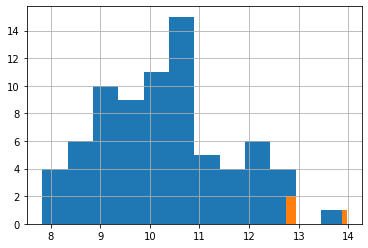

In [18]:
draft_PG['Metric'].hist(bins=12)
top_PGpick = draft_PG[draft_PG['Metric'] / draft_PG['Metric'].max() > 0.9]
top_PGpick['Metric'].hist(bins=12)

Blue region represents all players and Orange region represents top 10th percentile.

Coincidentally, the top 10th percentile NBA point guards are exactly the 5 draft top picks.

### Center

For Center, I will be using the following equation

$$ Fantasy_{C} = W_1 \frac{Player_{FG\%}}{TOP_{FG\%}} + W_2 \frac{Player_{3P\%}}{TOP_{3P\%}} + ... + W_n \frac{Player_{PTS}}{TOP_{PTS}}$$

The weights will all be 1 except for field goal, ORB, DRB, and BLK.

Weights are mostly focusing on diffensive statistics and short range scoring potential

Weights are the following:
- Field Goald: 1.3
- ORB: 1.4
- DRB: 1.25
- Blocks: 1.25
- TOV: -1



In [19]:
# Let's work on getting the denominators for Center
# We created this earlier when working on point guards.
top3stat_C

{'FG%': 0.5842,
 '3P%': 0.4398,
 '2P%': 0.6264,
 'eFG%': 0.6192,
 'FT%': 0.7016,
 'ORB': 0.0882,
 'DRB': 0.2111,
 'AST': 0.0391,
 'STL': 0.0244,
 'BLK': 0.0525,
 'TOV': 0.0483,
 'PTS': 0.4777}

In [20]:
# Now make the dictionary of weights to be used.

W_C = {'FG%': 1.3, '3P%': 1, '2P%': 1, 'eFG%': 1, 'FT%': 1, 'ORB': 1.2, 'DRB': 1.2,
        'AST': 1, 'STL': 1, 'BLK': 1.2, 'TOV': -1, 'PTS': 1}

In [21]:
# We have the weights and the denominator.
# Let's evaluate Fantasy Metrics for Center.

NBA_C = season_2021[season_2021['Pos'] == 'C']

draft_C = evaluate_metric(NBA_C, W_C, top3stat_C)

# Remove players with less than 256 minutes playing time
draft_C = draft_C[draft_C['MP'] > 256]

In [22]:
# Here are the top 5 drafts for Center.
draft_C.sort_values('Metric', axis=0, ascending = False).head(7)

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Metric
343,262,Nikola Jokic,C,25,DEN,72,72,2488,732,1293,0.566,92,237,0.388,640,1056,0.606,0.602,342,394,0.868,205,575,780,599,95,48,222,192,1898,15.666183
687,527,Robert Williams,C,23,BOS,52,13,985,186,258,0.721,0,2,0.000,186,256,0.727,0.721,45,73,0.616,133,225,358,94,43,91,52,105,417,14.077724
480,373,Jusuf Nurkic,C,26,POR,37,37,880,171,333,0.514,12,30,0.400,159,303,0.525,0.532,70,113,0.619,86,246,332,125,38,39,73,103,424,13.258302
3,4,Bam Adebayo,C,23,MIA,64,64,2143,456,800,0.570,2,8,0.250,454,792,0.573,0.571,283,354,0.799,142,431,573,346,75,66,169,145,1197,12.661495
191,148,Drew Eubanks,C,23,SAS,54,3,755,116,205,0.566,2,2,1.000,114,203,0.562,0.571,77,106,0.726,74,167,241,42,18,49,45,88,311,12.489835
275,210,Isaiah Hartenstein,C,22,TOT,46,2,559,94,171,0.550,2,6,0.333,92,165,0.558,0.556,46,71,0.648,65,116,181,55,19,39,44,104,236,12.213228
655,504,Nikola Vucevic,C,30,TOT,70,70,2348,666,1396,0.477,176,440,0.400,490,956,0.513,0.540,131,156,0.840,146,671,817,269,65,48,126,137,1639,12.211876


Here, using the Fantasy Metric I can see that my top 5 picks are Nikola Jokic, Robert Williams, Jusuf Nurkic, Bam Adebayo, and Drew Eubanks

Let's see what the distribution of the Fantasy Metric looks like in Center.

(array([4., 1., 0., 1., 0., 1., 0., 0., 0., 1.]),
 array([12.13947834, 12.4921488 , 12.84481926, 13.19748972, 13.55016018,
        13.90283064, 14.2555011 , 14.60817156, 14.96084203, 15.31351249,
        15.66618295]),
 <a list of 10 Patch objects>)

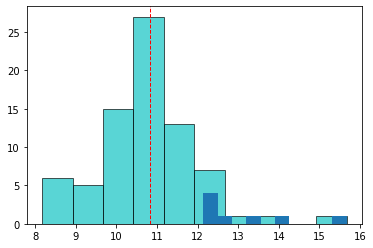

In [23]:
plt.hist(draft_C['Metric'], bins=10, color='c', edgecolor='k', alpha=0.65)

plt.axvline(draft_C['Metric'].mean(), color='r', linestyle='dashed', linewidth=1)

# Let's show top 10 percentile players metric on the same histogram
plt.hist(draft_C['Metric'].sort_values(ascending = False).head(round(len(draft_C['Metric'])/10)))


The light blue region represents all players and dark blue region represents top 10 percentile Center players in the NBA.

### Power Forward

For Power Forward I will be using the following equation

$$ Fantasy_{PF} = W_1 \frac{Player_{FG\%}}{TOP_{FG\%}} + W_2 \frac{Player_{3P\%}}{TOP_{3P\%}} + ... + W_n \frac{Player_{PTS}}{TOP_{PTS}}$$

The weights will all be 1 except for field goal, 2P%, ORB, DRB, and BLK.

Weights are mostly focusing on diffensive statistics and short range scoring potential

Weights are the following:
- Field Goald: 1.3
- 2P%: 1.4
- ORB: 1.2
- DRB: 1.2
- Blocks: 1.2
- TOV: -1

In [24]:
# Let's work on getting the denominators for Power Forward
# We created this earlier when working on point guards.
top3stat_PF

{'FG%': 0.4914,
 '3P%': 0.3494,
 '2P%': 0.527,
 'eFG%': 0.5554,
 'FT%': 0.8102,
 'ORB': 0.0491,
 'DRB': 0.1982,
 'AST': 0.1064,
 'STL': 0.0325,
 'BLK': 0.0346,
 'TOV': 0.0715,
 'PTS': 0.6454}

In [25]:
# Now make the dictionary of weights to be used.

W_PF = {'FG%': 1.3, '3P%': 1, '2P%': 1.4, 'eFG%': 1, 'FT%': 1, 'ORB': 1.2, 'DRB': 1.2,
        'AST': 1, 'STL': 1, 'BLK': 1.2, 'TOV': -1, 'PTS': 1}

In [26]:
# We have the weights and the denominator.
# Let's evaluate Fantasy Metrics for Power Forward.

NBA_PF = season_2021[season_2021['Pos'] == 'PF']

draft_PF = evaluate_metric(NBA_PF, W_PF, top3stat_PF)

# Remove players with less than 256 minutes playing time
draft_PF = draft_PF[draft_PF['MP'] > 256]

In [27]:
# Here are the top 5 drafts for Power Forward.
draft_PF.sort_values('Metric', axis=0, ascending = False).head(7)

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Metric
649,498,Jarred Vanderbilt,PF,21,MIN,64,30,1139,143,236,0.606,1,5,0.200,142,231,0.615,0.608,57,102,0.559,118,250,368,76,64,46,53,123,344,13.028760
223,174,Taj Gibson,PF,35,NYK,45,3,936,99,158,0.627,3,15,0.200,96,143,0.671,0.636,40,55,0.727,99,151,250,36,31,49,22,99,241,12.884225
17,12,Giannis Antetokounmpo,PF,26,MIL,61,61,2013,626,1100,0.569,67,221,0.303,559,879,0.636,0.600,398,581,0.685,97,574,671,357,72,73,207,168,1717,12.800372
701,537,Thaddeus Young,PF,32,CHI,68,23,1652,370,662,0.559,12,45,0.267,358,617,0.580,0.568,71,113,0.628,168,255,423,291,74,40,137,152,823,12.487212
577,444,Domantas Sabonis,PF,24,IND,62,62,2231,484,904,0.535,52,162,0.321,432,742,0.582,0.564,240,328,0.732,150,592,742,415,76,33,213,203,1260,11.898128
153,118,Anthony Davis,PF,27,LAL,36,36,1162,301,613,0.491,26,100,0.260,275,513,0.536,0.512,158,214,0.738,62,224,286,110,45,59,74,60,786,11.770518
128,101,Brandon Clarke,PF,24,MEM,59,16,1415,256,495,0.517,20,77,0.260,236,418,0.565,0.537,78,113,0.690,97,231,328,95,60,51,33,84,610,11.622604


Let's see what the distribution of the metric looks like for Power Forward players.

(array([2., 1., 1., 0., 0., 0., 1., 0., 2., 1.]),
 array([11.60263231, 11.74524513, 11.88785795, 12.03047077, 12.17308358,
        12.3156964 , 12.45830922, 12.60092204, 12.74353486, 12.88614767,
        13.02876049]),
 <a list of 10 Patch objects>)

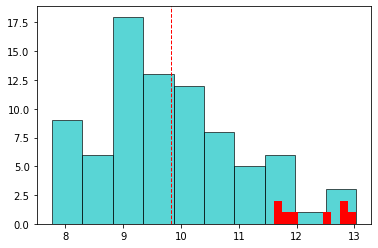

In [28]:
plt.hist(draft_PF['Metric'], bins=10, color='c', edgecolor='k', alpha=0.65)

plt.axvline(draft_PF['Metric'].mean(), color='r', linestyle='dashed', linewidth=1)

# Let's show top 10 percentile players metric on the same histogram
plt.hist(draft_PF['Metric'].sort_values(ascending = False).head(round(len(draft_PF['Metric'])/10)), color = 'r')


Note that the distribution looks similar to normal distribution with mean approximately 10 and skewed a little bit to the right.

### Small Forward

For Small Forward I will be using the following equation

$$ Fantasy_{SF} = W_1 \frac{Player_{FG\%}}{TOP_{FG\%}} + W_2 \frac{Player_{3P\%}}{TOP_{3P\%}} + ... + W_n \frac{Player_{PTS}}{TOP_{PTS}}$$

The weights will all be 1 except for effective Field Goal%, steals, and assists

Weights are the following:
- eFG%: 1.3
- STL: 1.2
- AST: 1.25

In [29]:
# Let's work on getting the denominators for Power Forward
# We created this earlier when working on point guards.
top3stat_SF

{'FG%': 0.4746,
 '3P%': 0.362,
 '2P%': 0.5292,
 'eFG%': 0.5412,
 'FT%': 0.7206,
 'ORB': 0.039,
 'DRB': 0.15,
 'AST': 0.1031,
 'STL': 0.0407,
 'BLK': 0.0111,
 'TOV': 0.0649,
 'PTS': 0.5839}

In [30]:
# Now make the dictionary of weights to be used.

W_SF = {'FG%': 1, '3P%': 1, '2P%': 1, 'eFG%': 1.3, 'FT%': 1, 'ORB': 1, 'DRB': 1,
        'AST': 1.25, 'STL': 1.2, 'BLK': 1, 'TOV': -1, 'PTS': 1}

In [31]:
# We have the weights and the denominator.
# Let's evaluate Fantasy Metrics for Small Forward.

NBA_SF = season_2021[season_2021['Pos'] == 'SF']

draft_SF = evaluate_metric(NBA_SF, W_SF, top3stat_SF)

# Remove players with less than 256 minutes playing time
draft_SF = draft_SF[draft_SF['MP'] > 256]

In [32]:
# Here are the top 5 drafts for Small Forward.
draft_SF.sort_values('Metric', axis=0, ascending = False).head(7)

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Metric
88,68,Oshae Brissett,SF,22,IND,21,16,519,73,151,0.483,33,78,0.423,40,73,0.548,0.593,50,65,0.769,29,86,115,18,19,20,10,32,229,13.681078
145,112,Torrey Craig,SF,30,TOT,50,8,803,109,227,0.480,39,106,0.368,70,121,0.579,0.566,17,22,0.773,57,140,197,49,28,26,25,83,274,13.326326
419,320,Kenyon Martin Jr.,SF,20,HOU,45,8,1068,162,318,0.509,35,96,0.365,127,222,0.572,0.564,60,84,0.714,73,169,242,48,30,41,38,89,419,13.270089
106,84,Jimmy Butler,SF,31,MIA,52,52,1745,366,736,0.497,25,102,0.245,341,634,0.538,0.514,359,416,0.863,94,265,359,369,108,18,109,71,1116,13.017260
527,410,Michael Porter Jr.,SF,22,DEN,61,54,1912,443,817,0.542,170,382,0.445,273,435,0.628,0.646,106,134,0.791,91,354,445,70,40,54,77,126,1162,12.687487
418,319,Kelan Martin,SF,25,IND,35,0,322,62,138,0.449,24,60,0.400,38,78,0.487,0.536,9,10,0.900,18,60,78,17,10,10,16,35,157,12.606325
348,264,Derrick Jones Jr.,SF,23,POR,58,43,1318,147,304,0.484,43,136,0.316,104,168,0.619,0.554,59,91,0.648,77,128,205,47,37,54,32,127,396,12.529473


Let's see what the distribution of small forwards fantasy metric looks like

(array([2., 1., 0., 0., 1., 0., 2., 0., 0., 1.]),
 array([12.52947271, 12.64463328, 12.75979385, 12.87495441, 12.99011498,
        13.10527555, 13.22043612, 13.33559669, 13.45075725, 13.56591782,
        13.68107839]),
 <a list of 10 Patch objects>)

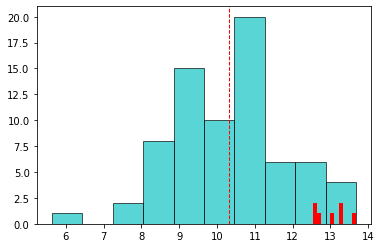

In [33]:
plt.hist(draft_SF['Metric'], bins=10, color='c', edgecolor='k', alpha=0.65)

plt.axvline(draft_SF['Metric'].mean(), color='r', linestyle='dashed', linewidth=1)

# Let's show top 10 percentile players metric on the same histogram
plt.hist(draft_SF['Metric'].sort_values(ascending = False).head(round(len(draft_SF['Metric'])/10)), color = 'r')


This distribution looks a little different from the previous ones. Normal distribution with mean approximately 10 with little to no skewness.

Top 10 percentile Small Forwards players are indicated as red bars in the histogram.

### Shooting Guard

Now for shooting guard. Perhaps the most important position in NBA.

I'll be using the following equation as always.

$$ Fantasy_{SG} = W_1 \frac{Player_{FG\%}}{TOP_{FG\%}} + W_2 \frac{Player_{3P\%}}{TOP_{3P\%}} + ... + W_n \frac{Player_{PTS}}{TOP_{PTS}}$$

The weights will all be 1 except for 3P%, AST, PTS

Weights are the following:
- 3P%: 1.5
- AST: 1.35
- PTS: 1.2

I put the most weight on the 3 pointer shoot percentage rate because for shooting guards this is the most effective ways of scoring points for the team.

In [34]:
# Let's work on getting the denominators for Power Forward
# We created this earlier when working on point guards.
top3stat_SG

{'FG%': 0.4502,
 '3P%': 0.3966,
 '2P%': 0.5217,
 'eFG%': 0.5659,
 'FT%': 0.7784,
 'ORB': 0.0266,
 'DRB': 0.1119,
 'AST': 0.0638,
 'STL': 0.0347,
 'BLK': 0.0123,
 'TOV': 0.0377,
 'PTS': 0.3781}

In [35]:
# Now make the dictionary of weights to be used.

W_SG = {'FG%': 1, '3P%': 1, '2P%': 1, 'eFG%': 1.3, 'FT%': 1, 'ORB': 1, 'DRB': 1,
        'AST': 1.25, 'STL': 1.2, 'BLK': 1, 'TOV': -1, 'PTS': 1}

In [36]:
# We have the weights and the denominator.
# Let's evaluate Fantasy Metrics for Small Forward.

NBA_SG = season_2021[season_2021['Pos'] == 'SG']

draft_SG = evaluate_metric(NBA_SG, W_SG, top3stat_SG)

# Remove players with less than 256 minutes playing time
draft_SG = draft_SG[draft_SG['MP'] > 256]

In [37]:
# Here are the top 5 drafts for Shooting Guard.
draft_SG.sort_values('Metric', axis=0, ascending = False).head(7)

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Metric
631,484,Matisse Thybulle,SG,23,PHI,65,8,1298,102,243,0.420,43,143,0.301,59,100,0.590,0.508,8,18,0.444,30,94,124,63,105,71,32,127,255,14.137438
368,278,John Konchar,SG,24,MEM,43,0,575,69,138,0.500,21,56,0.375,48,82,0.585,0.576,25,30,0.833,35,93,128,47,30,9,18,40,184,13.998828
636,489,Juan Toscano-Anderson,SG,27,GSW,53,16,1107,121,209,0.579,37,92,0.402,84,117,0.718,0.667,22,31,0.710,29,205,234,150,41,26,61,111,301,13.862749
379,284,Jeremy Lamb,SG,28,IND,36,8,765,120,276,0.435,52,128,0.406,68,148,0.459,0.529,71,75,0.947,25,106,131,53,34,23,22,72,363,13.599292
392,295,Caris LeVert,SG,26,TOT,47,39,1486,359,814,0.441,84,258,0.326,275,556,0.495,0.493,146,180,0.811,33,181,214,245,66,30,102,105,948,13.122243
650,499,Fred VanVleet,SG,26,TOR,52,52,1899,338,870,0.389,174,476,0.366,164,394,0.416,0.489,169,191,0.885,32,188,220,328,87,37,95,119,1019,13.007489
225,176,Shai Gilgeous-Alexander,SG,22,OKC,35,35,1180,287,565,0.508,71,170,0.418,216,395,0.547,0.571,185,229,0.808,19,147,166,207,27,23,106,70,830,12.589697


Now let's take a look at the distribution of the metric in shooting guards

(array([3., 1., 0., 1., 1., 0., 1., 0., 1., 2.]),
 array([12.34500925, 12.5242521 , 12.70349495, 12.8827378 , 13.06198065,
        13.2412235 , 13.42046635, 13.5997092 , 13.77895205, 13.9581949 ,
        14.13743775]),
 <a list of 10 Patch objects>)

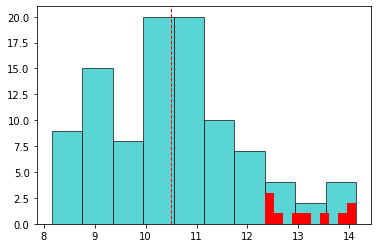

In [38]:
plt.hist(draft_SG['Metric'], bins=10, color='c', edgecolor='k', alpha=0.65)

plt.axvline(draft_SG['Metric'].mean(), color='r', linestyle='dashed', linewidth=1)

# Let's show top 10 percentile players metric on the same histogram
plt.hist(draft_SG['Metric'].sort_values(ascending = False).head(round(len(draft_SG['Metric'])/10)), color = 'r')

The distribution looks pretty normal with mean of approximatly 10.5 and skewed a little bit to the right.

## 3) Slump

When drafting our players, I think it's pretty important to know how their performance changed over the years.

Is there an upward trend in player's performance over the years? Or
Is there a downward trend (i.e slump) in player's performance over they years?

Let's try to dwelve on this idea

In [59]:
# First let's only consider the top 7 players in each position from 2021 season.
# Then we'll compare their performance in 2020 and 2019 (if applicable) in the same manner.

draft_2022 = pd.concat([draft_PG.sort_values('Metric', axis=0, ascending = False).head(7), 
                       draft_SG.sort_values('Metric', axis=0, ascending = False).head(7), 
                        draft_C.sort_values('Metric', axis=0, ascending = False).head(7), 
                        draft_PF.sort_values('Metric', axis=0, ascending = False).head(7), 
                        draft_SF.sort_values('Metric', axis=0, ascending = False).head(7)])
draft_2022

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Metric
92,72,Bruce Brown,PG,24,BRK,65,37,1451,235,423,0.556,17,59,0.288,218,364,0.599,0.576,86,117,0.735,111,238,349,104,58,28,54,145,573,13.961426
592,457,Ben Simmons,PG,24,PHI,58,58,1877,325,583,0.557,3,10,0.300,322,573,0.562,0.560,176,287,0.613,93,324,417,401,93,35,173,171,829,12.900329
293,224,Jrue Holiday,PG,30,MIL,59,56,1907,414,823,0.503,111,283,0.392,303,540,0.561,0.570,107,136,0.787,73,195,268,357,96,37,127,98,1046,12.891503
445,340,De'Anthony Melton,PG,22,MEM,52,1,1045,172,393,0.438,87,211,0.412,85,182,0.467,0.548,41,51,0.804,30,131,161,132,60,31,66,85,472,12.815305
316,243,Kyrie Irving,PG,28,BRK,54,54,1886,549,1086,0.506,152,378,0.402,397,708,0.561,0.576,201,218,0.922,52,205,257,324,76,37,130,140,1451,12.752149
52,43,Patrick Beverley,PG,32,LAC,37,34,832,93,220,0.423,56,141,0.397,37,79,0.468,0.550,36,45,0.800,29,90,119,76,29,28,34,108,278,12.376197
428,329,T.J. McConnell,PG,28,IND,69,3,1796,274,490,0.559,15,48,0.313,259,442,0.586,0.574,33,48,0.688,55,201,256,456,128,23,135,113,596,12.351223
631,484,Matisse Thybulle,SG,23,PHI,65,8,1298,102,243,0.420,43,143,0.301,59,100,0.590,0.508,8,18,0.444,30,94,124,63,105,71,32,127,255,14.137438
368,278,John Konchar,SG,24,MEM,43,0,575,69,138,0.500,21,56,0.375,48,82,0.585,0.576,25,30,0.833,35,93,128,47,30,9,18,40,184,13.998828
636,489,Juan Toscano-Anderson,SG,27,GSW,53,16,1107,121,209,0.579,37,92,0.402,84,117,0.718,0.667,22,31,0.710,29,205,234,150,41,26,61,111,301,13.862749


In [62]:
# Now evaluate Player's 2020 and 2019 metric

slump_2020 = season_2020.loc[season_2020['Player'].isin(list(draft_2022['Player']))]

PF_2020 = evaluate_metric(slump_2020[slump_2020['Pos'] == 'PF'], W_PF, top3stat_PF)
SF_2020 = evaluate_metric(slump_2020[slump_2020['Pos'] == 'SF'], W_SF, top3stat_SF)
C_2020 = evaluate_metric(slump_2020[slump_2020['Pos'] == 'C'], W_C, top3stat_C)
SG_2020 = evaluate_metric(slump_2020[slump_2020['Pos'] == 'SG'], W_SG, top3stat_SG)
PG_2020 = evaluate_metric(slump_2020[slump_2020['Pos'] == 'PG'], W_PG, top3stat_PG)
                                     
slump_2020 = pd.concat([PF_2020, SF_2020, C_2020, SG_2020, PG_2020])

# For 2019..
slump_2019 = season_2019.loc[season_2019['Player'].isin(list(draft_2022['Player']))]

PF_2019 = evaluate_metric(slump_2019[slump_2019['Pos'] == 'PF'], W_PF, top3stat_PF)
SF_2019 = evaluate_metric(slump_2019[slump_2019['Pos'] == 'SF'], W_SF, top3stat_SF)
C_2019 = evaluate_metric(slump_2019[slump_2019['Pos'] == 'C'], W_C, top3stat_C)
SG_2019 = evaluate_metric(slump_2019[slump_2019['Pos'] == 'SG'], W_SG, top3stat_SG)
PG_2019 = evaluate_metric(slump_2019[slump_2019['Pos'] == 'PG'], W_PG, top3stat_PG)
                                     
slump_2019 = pd.concat([PF_2019, SF_2019, C_2019, SG_2019, PG_2019])


In [79]:
slump_2020

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Metric
1,2,Bam Adebayo,PF,22,MIA,72,72,2417,440,790,0.557,2,14,0.143,438,776,0.564,0.558,264,382,0.691,176,559,735,368,82,93,204,182,1146,11.782126
12,13,Giannis Antetokounmpo,PF,25,MIL,63,63,1917,685,1238,0.553,89,293,0.304,596,945,0.631,0.589,398,629,0.633,140,716,856,354,61,66,230,195,1857,13.628930
129,102,Brandon Clarke,PF,23,MEM,58,4,1300,296,479,0.618,23,64,0.359,273,415,0.658,0.642,85,112,0.759,92,253,345,81,32,48,55,100,700,12.277179
162,123,Anthony Davis,PF,26,LAL,62,62,2131,551,1096,0.503,72,218,0.330,479,878,0.546,0.536,444,525,0.846,142,435,577,200,91,143,154,156,1618,13.288408
534,436,Domantas Sabonis,PF,23,IND,62,62,2159,458,848,0.540,17,67,0.254,441,781,0.565,0.550,214,296,0.723,189,582,771,310,47,30,170,195,1147,11.533840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,70,Bruce Brown,PG,23,DET,58,43,1634,198,447,0.443,33,96,0.344,165,351,0.470,0.480,88,119,0.739,61,213,274,230,63,29,100,162,517,11.134490
308,241,Kyrie Irving,PG,27,BRK,20,20,658,199,416,0.478,56,142,0.394,143,274,0.522,0.546,94,102,0.922,22,81,103,128,27,10,52,53,548,12.656995
403,324,T.J. McConnell,PG,27,IND,71,3,1326,212,411,0.516,5,17,0.294,207,394,0.525,0.522,35,42,0.833,38,151,189,355,56,11,100,73,464,10.929515
416,334,De'Anthony Melton,PG,21,MEM,60,8,1167,161,401,0.401,40,140,0.286,121,261,0.464,0.451,93,121,0.769,43,177,220,175,77,20,84,109,455,11.751187


In [78]:
slump_2019

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Metric
19,18,Giannis Antetokounmpo,PF,24,MIL,72,72,2358,721,1247,0.578,52,203,0.256,669,1044,0.641,0.599,500,686,0.729,159,739,898,424,92,110,268,232,1994,13.717416
204,157,Drew Eubanks,PF,21,SAS,23,0,113,15,26,0.577,0,0,0.000,15,26,0.577,0.577,11,13,0.846,6,28,34,7,2,5,8,11,41,10.173705
241,184,Taj Gibson,PF,33,MIN,70,57,1686,304,537,0.566,11,34,0.324,293,503,0.583,0.576,134,177,0.757,172,286,458,84,53,39,73,186,753,11.789357
282,216,Isaiah Hartenstein,PF,20,HOU,28,0,221,20,41,0.488,2,6,0.333,18,35,0.514,0.512,11,14,0.786,21,26,47,15,7,12,13,56,53,11.580723
659,490,Jarred Vanderbilt,PF,19,DEN,17,0,69,9,19,0.474,0,1,0.000,9,18,0.500,0.474,6,10,0.600,7,16,23,3,6,1,8,8,24,10.563809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321,249,Kyrie Irving,PG,26,BOS,67,67,2214,604,1241,0.487,174,434,0.401,430,807,0.533,0.557,214,245,0.873,71,264,335,464,103,34,172,167,1596,12.659942
447,335,T.J. McConnell,PG,26,PHI,76,3,1470,220,419,0.525,14,42,0.333,206,377,0.546,0.542,29,37,0.784,28,146,174,258,79,17,91,105,483,10.834770
456,344,De'Anthony Melton,PG,20,PHO,50,31,984,100,256,0.391,29,95,0.305,71,161,0.441,0.447,21,28,0.750,25,109,134,159,68,23,75,113,250,11.164963
599,449,Ben Simmons,PG,22,PHI,79,79,2700,540,960,0.563,0,6,0.000,540,954,0.566,0.563,257,428,0.600,172,525,697,610,112,61,274,209,1337,12.597913


In [85]:
# We can merge 3 datasets into one using Player column as 'key'
# Drop unnecessary columns and rename

compare1 = draft_2022[['Player', 'Pos', 'Metric']].merge(slump_2020[['Player', 'Pos', 'Metric']], on='Player', how='left')
slump_compare = compare1.merge(slump_2019[['Player', 'Pos', 'Metric']], on='Player', how='left')

pd.set_option('display.max_rows', None)

slump_compare = slump_compare.drop(slump_compare.columns[[3, 5]], axis=1)
slump_compare.rename(columns={"Pos_x": "Pos", "Metric_x": "Metric_2020", "Metric_y": "Metric_2019"})

,Player,Pos,Metric_2020,Metric_2019,Metric
0,Bruce Brown,PG,13.961426,11.134490,10.411129
1,Ben Simmons,PG,12.900329,13.334367,12.597913
2,Jrue Holiday,PG,12.891503,13.640843,14.093319
3,De'Anthony Melton,PG,12.815305,11.751187,11.164963
4,Kyrie Irving,PG,12.752149,12.656995,12.659942
5,Patrick Beverley,PG,12.376197,12.062999,11.552125
6,T.J. McConnell,PG,12.351223,10.929515,10.834770
7,Matisse Thybulle,SG,14.137438,12.827020,NaN
8,John Konchar,SG,13.998828,16.338925,NaN
9,Juan Toscano-Anderson,SG,13.862749,11.667544,NaN


The above chart shows you each player's metric over the past 3 years. You can clearly see who has been improving and who has been on a slippery slope. This will allow fantasy players to make more accurately informed decision on their draft.

For example: 
- Anthony Davis's (index: 26) score decreased from 14.6 to 11.7 in just 3 seasons. This is nearly 20% performance decrease! Sorry Anthony :(
- Bruce Brown's (index: 0) score increased from 10.4 to 13.96. This is about 34% performance improvement. We should consider drafting him!
- Kyrie Irving's (index: 4) score generally stayed the same over the last 3 seasons, hovering at around 12.7 He seems like a consistent player.

So here it is! My analysis on NBA players statistics over the last 3 championships. For those of you who decided to take a look at this document, I hope this sparked your interest as it definitely did mine.

This was my first unique sports analysis project that I've done. I'm really excited and happy about the outcome.
Some of the well known players really do have high performance in terms of metric. Although I was pretty shocked that I didn't see Lebron James on the list of top picks.

Young athlethes are starting to dominate the playing field now. But it's too soon to neglect the wisdom and experience of veteran athlethes. 

Should you follow my draft pick recommendation, choose your players carefully!

Thanks for reading!

Email me any suggestions/improvements/ideas you have, much appreciated!
## **Work done by Harold**